# MobileNet Implementation:
#### Yassin Bahid

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import time
from PIL import Image
import os.path

## Introduction:

Since AlexNet, Deep Neural Networks have become ubiquitous. However, the evermore large and more complex architectures have solely focused on accuracy to the detriment of Latency and speed. While reaching high levels of accuracy is excellent when one has access to powerful systems, they are less practical when using smaller machines such as smartphones. A. Howard's answer to this problem is his MobileNet architecture from his 2017 Paper. We shall explore the first two versions of this architecture. We shall then compare the latency and accuracy of the model. In order to mimic the slow performance of certain machines, we shall compare the times needed to commpute accuracies on the test data on the CPU.

## Results & Conclusion:

In [18]:
### Defining Cuda and CPU:

cudaDevice = torch.device("cuda")
cpuDevice =torch.device("cpu")

### Loading models:

# load model architecture
mbnetv1cuda = MobileNetV1(3, 10)
mbnetv1cpu = MobileNetV1(3, 10)
mbnetv2cuda = MobileNetV2(3, 10)
mbnetv2cpu = MobileNetV2(3, 10)
mbnetv275cuda = MobileNetV2(3, 10, alpha = 0.75)
mbnetv275cpu = MobileNetV2(3, 10, alpha = 0.75)
mbnetv250cuda = MobileNetV2(3, 10, alpha = 0.50)
mbnetv250cpu = MobileNetV2(3, 10, alpha = 0.50)
# fill architecture with the trained weights
mbnetv1cuda.load_state_dict(torch.load("MobileNetV1.pt"))
mbnetv1cpu.load_state_dict(torch.load("MobileNetV1.pt"))
mbnetv2cuda.load_state_dict(torch.load("MobileNetV2.pt"))
mbnetv2cpu.load_state_dict(torch.load("MobileNetV2.pt"))
mbnetv275cuda.load_state_dict(torch.load("MobileNetV275.pt"))
mbnetv275cpu.load_state_dict(torch.load("MobileNetV275.pt"))
mbnetv250cuda.load_state_dict(torch.load("MobileNetV250.pt"))
mbnetv250cpu.load_state_dict(torch.load("MobileNetV250.pt"))
# Assigning the model to appropriate device
mbnetv1cuda = mbnetv1cuda.to(cudaDevice)
mbnetv1cpu = mbnetv1cpu.to(cpuDevice)
mbnetv2cuda = mbnetv2cuda.to(cudaDevice)
mbnetv2cpu = mbnetv2cpu.to(cpuDevice)
mbnetv275cuda = mbnetv275cuda.to(cudaDevice)
mbnetv275cpu = mbnetv275cpu.to(cpuDevice)
mbnetv250cuda = mbnetv250cuda.to(cudaDevice)
mbnetv250cpu = mbnetv250cpu.to(cpuDevice)

## getting times and accuracies:
Model_list_name = [
              'mbnetv1' , 
              'mbnetv2' ,  
              'mbnetv275', 
              'mbnetv250']
Model_list_cuda = [
              mbnetv1cuda ,
              mbnetv2cuda ,
              mbnetv275cuda,
              mbnetv250cuda]

Model_list_cpu = [mbnetv1cpu,
                  mbnetv2cpu,
                  mbnetv275cpu,
                  mbnetv250cpu,
                    ]

acc_lst_cuda = []
runtimes_cuda = []

acc_lst_cpu = []
runtimes_cpu = []

num_weight = []
for m in range(0, len(Model_list_cuda)):
    acc_cuda, time_cuda = AccuracyCalculator_perdevice(Model_list_cuda[m], cudaDevice)
    acc_cpu, time_cpu = AccuracyCalculator_perdevice(Model_list_cpu[m], cpuDevice)
    acc_lst_cuda += [acc_cuda]
    acc_lst_cpu += [acc_cpu]
    runtimes_cuda += [time_cuda]
    runtimes_cpu += [time_cpu]
    num_weight += [sum(p.numel() for p in Model_list_cuda[m].parameters())]

Accuracy : 70 %
Accuracy : 70 %
Accuracy : 83 %
Accuracy : 83 %
Accuracy : 82 %
Accuracy : 82 %
Accuracy : 79 %
Accuracy : 79 %


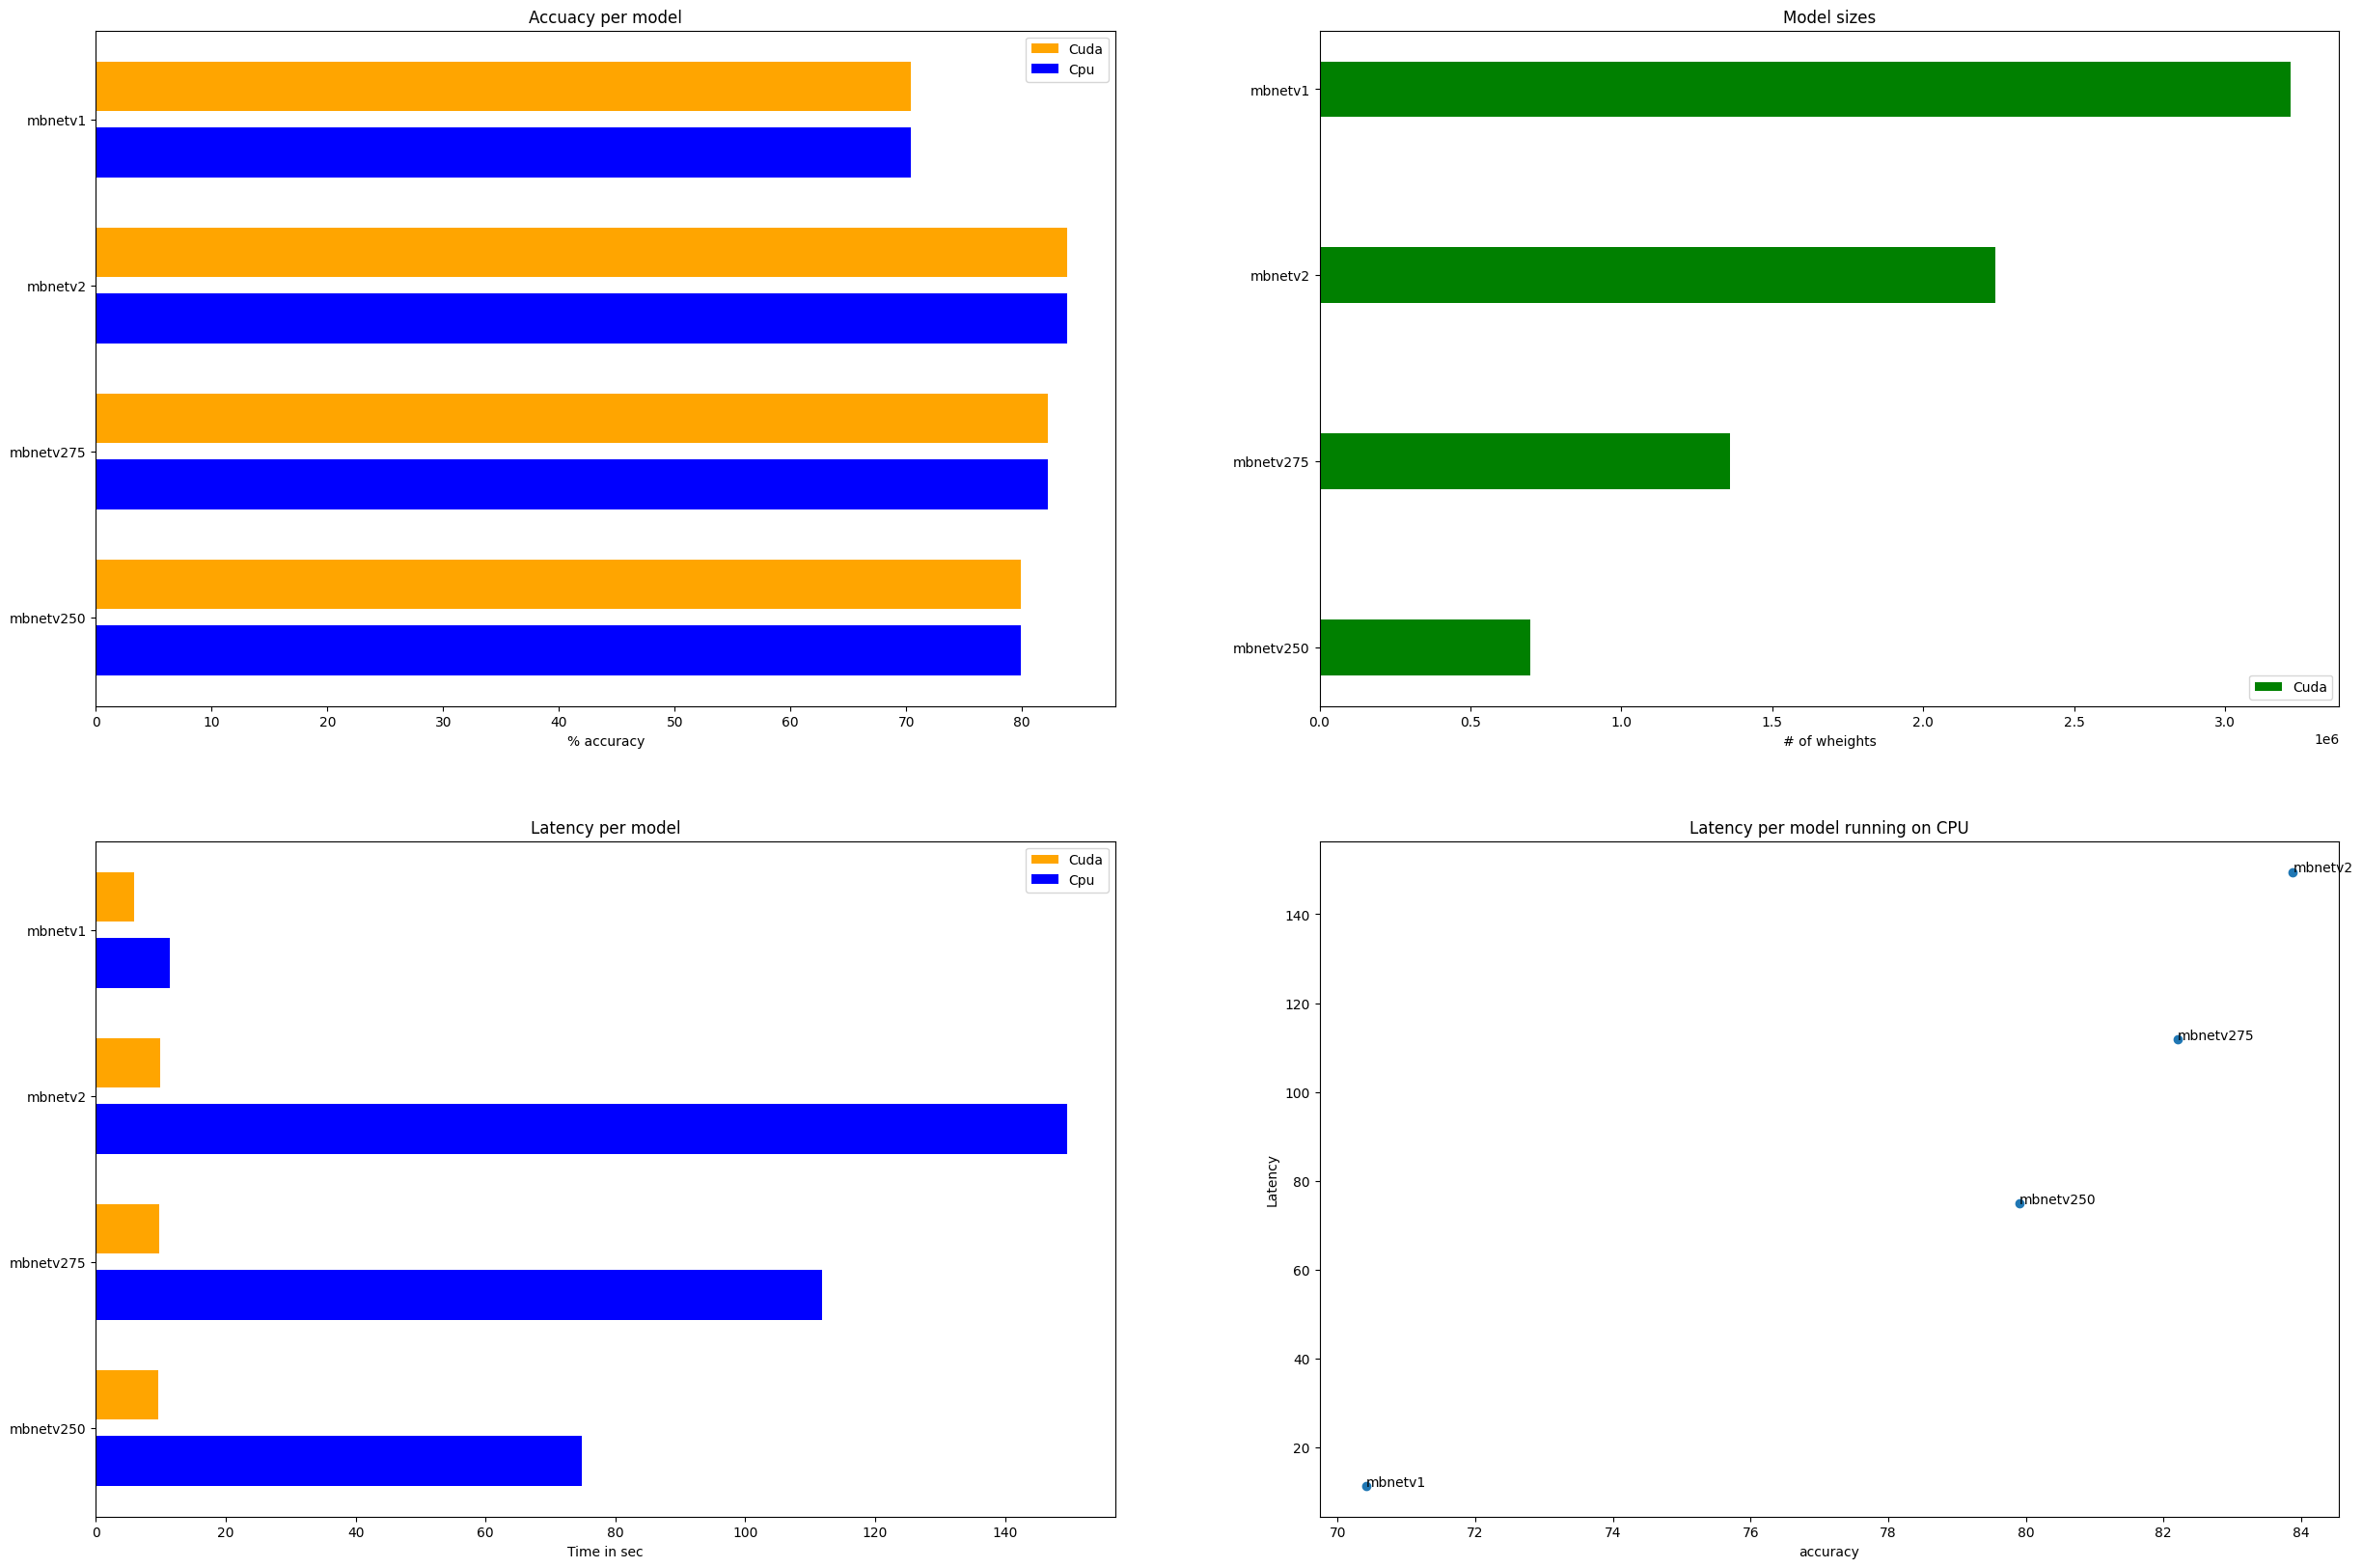

In [39]:
## Plotting 
xpos = np.arange(len(Model_list_name))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,20))

## Accuracies
axes[0,0].barh(xpos-0.2, acc_lst_cuda, 0.3, align='center', label = 'Cuda', color = 'orange')
axes[0,0].barh(xpos+0.2, acc_lst_cpu,0.3, align='center', label = 'Cpu', color = 'blue')
axes[0,0].set_yticks(xpos, labels=Model_list_name)
axes[0,0].invert_yaxis()  # labels read top-to-bottom
axes[0,0].set_xlabel('% accuracy')
axes[0,0].legend()
axes[0,0].set_title('Accuacy per model')

## Size
axes[0,1].barh(xpos, num_weight, 0.3, align='center', label = 'Cuda', color = 'green')
axes[0,1].set_yticks(xpos, labels=Model_list_name)
axes[0,1].invert_yaxis()  # labels read top-to-bottom
axes[0,1].set_xlabel('# of wheights')
axes[0,1].legend()
axes[0,1].set_title('Model sizes')

## Latency
axes[1,0].barh(xpos-0.2, runtimes_cuda, 0.3, align='center', label = 'Cuda', color = 'orange')
axes[1,0].barh(xpos+0.2, runtimes_cpu,0.3, align='center', label = 'Cpu', color = 'blue')
axes[1,0].set_yticks(xpos, labels=Model_list_name)
axes[1,0].invert_yaxis()  # labels read top-to-bottom
axes[1,0].set_xlabel('Time in sec')
axes[1,0].legend()
axes[1,0].set_title('Latency per model')


## Accuracy vs Latency

axes[1,1].scatter(acc_lst_cpu, runtimes_cpu, marker = 'o')
for i, txt in enumerate(Model_list_name):
    axes[1,1].annotate(txt, (acc_lst_cpu[i], runtimes_cpu[i]))
    
axes[1,1].set_xlabel('accuracy')
axes[1,1].set_ylabel('Latency')
axes[1,1].set_title('Latency per model running on CPU')


# epochs = [i+1 for i in range(20)] 
# axes[2].plot(epochs, np.array(mgg_losses)[:,1], color = 'blue', label = 'Mini GoogleNet' )
# axes[2].plot(epochs, np.array(minivgg11_losses)[:,1], color = 'orange', label = 'Mini Vgg11' )
# axes[2].plot(epochs, np.array(minibtvg11_losses)[:,1], color = 'green', label = 'Mini Vgg11 w/ BN' )
# axes[2].legend
# axes[2].set_title('Losses per Epoch')
plt.show()

### Summary:

While MobileNet version 1 is relatively fast on both CPU and GPU, it vastly underperforms compared to MobileNet version 2. There is virtually no time difference when running the different models on GPU due to the parallelization on the Cuda cores. However, when run on a CPU, which mimics a low-performing system, there are some heavy discrepancies. The decay of accuracy on Mobile net version 2 is vastly smaller than the rate of change of latency as alpha gets smaller. Thus, the second version MobileNet architecture offers a great example of a structuree that greatly reduces the size and computation time without sacrifficing accuracy.

## Data:
We use the CIFAR10 which consist of 10 calsses and 60000 images. This dataset was provided by the university of toronto: https://www.cs.toronto.edu/~kriz/cifar.html.
The classes used are:




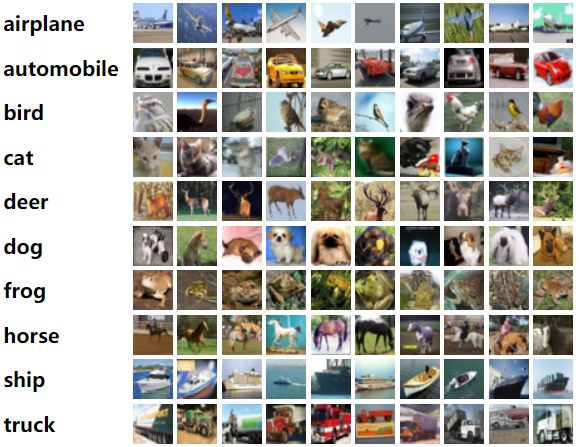


We transform the data into a tensor before nomalizing it.

In [14]:

## Getting Data:

transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        transform=transform, download = True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       transform=transform, download = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## MobileNet Architechture:

### Version 1:
For any Convolutionnal Neural Network, given an imput size of $D_i \times D_i \times M$, a kernel size $D_k \times D_k \times M$, and an output dimension od $D_o$, the total number of multiplications needed is: 


$$
N \times D_k \times D_k \times D_o \times M 
$$.
Which is rather espensive to do.

##### Depthwise Convolution:
We define Depthwise convolution as a convolution applies to a single channel. Thus, the kernel size is then:


$$
D_k \times D_k \times 1
$$


Thus, the total number of multiplications needed is N times smaller:


$$
D_k \times D_k \times D_o \times D_o \times M 
$$

##### Pointwise Convolution:
We define pointwise convolution as a 1x1 convolution applied to M channels. Thus the kernel Size is now:

$$
1 \times 1 \times M
$$

Thus, the total number of multiplications needed is:

$$
N \times D_o \times D_o \times M
$$

##### Total Multiplications Needed:

If instead of a conventional convolution, we use both pointwise and depthwise convolutions, thuse reducing the total number multiplications to:

$$
D_o^2 \times M \times (D_k^2 + N )
$$

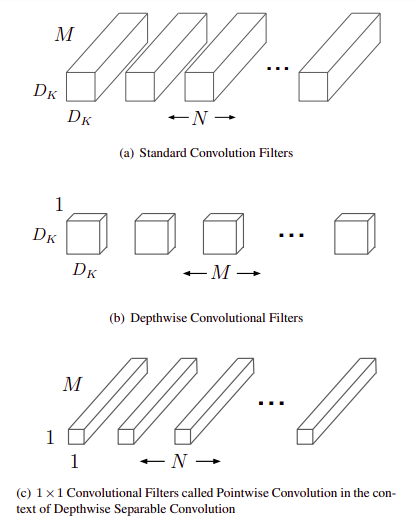



### Version 2:
We can construct an even less computationally heavy model. We intrduce a new parameter $\alpha \in (0,1]$ that acts as a thinner. We multiply the input channel $M$ and output channel $N$. The total number of operations needed is now:
 
$$
D_o^2 \times \alpha \times M \times (D_k^2  + \alpha \times N)
$$

##### Architechture:
We use depthwise and pointwise convolutional layers before a bbatch normalization and Relu. The last layer is followed by a softmax activation function.

## Model Implementation:

### Model Trainer:

This function is used to train our model

In [3]:
def model_trainer(model, loss_fct, optimizer_fct, epoch = 20, lr = 0.001, momentum = 0.9):
    model_losses = [] ##register  epoch & loss
    optimizer = optim.SGD(model.parameters(), lr, momentum)
    train_time_model = time.time()

    for ep in range(epoch):  

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data  
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)        

            loss = loss_fct(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        model_losses +=[[ep+1, running_loss / 6250]] 
        print('epoch : %d , loss = %.3f' % (ep+1, running_loss / 6250))

        if (running_loss / 6250) < 0.05:
            break
    train_time_model = time.time() - train_time_model
    return train_time_model

In [4]:
loss_fct = nn.CrossEntropyLoss()
optimizer_fct = optim.SGD

In [5]:
def AccuracyCalculator(model):
    ##Testing:
    testing_time = time.time()
    correct = 0
    total = 0
    with torch.no_grad(): 
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy : %d %%' % (
        100 * correct / total))
    testing_time = time.time() - testing_time
    return 100 * correct / total, testing_time

In [6]:
def AccuracyCalculator_perdevice(model, dev):
    ##Testing:
    testing_time = time.time()
    correct = 0
    total = 0
    with torch.no_grad(): 
        for data in testloader:
            images, labels = data
            images, labels = images.to(dev), labels.to(dev)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy : %d %%' % (
        100 * correct / total))
    testing_time = time.time() - testing_time
    return 100 * correct / total, testing_time

### MobileNet Version 1:


In [7]:
class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
mobilev1 = MobileNetV1(3, 10)
mobilev1 = mobilev1.to(device)

print(device)

cuda


In [11]:
model_trainer(mobilev1, loss_fct, optimizer_fct, epoch = 35)
torch.save(mobilev1.state_dict(), "MobileNetV1.pt")

epoch : 1 , loss = 2.006
epoch : 2 , loss = 1.701
epoch : 3 , loss = 1.549
epoch : 4 , loss = 1.429
epoch : 5 , loss = 1.313
epoch : 6 , loss = 1.221
epoch : 7 , loss = 1.130
epoch : 8 , loss = 1.060
epoch : 9 , loss = 1.000
epoch : 10 , loss = 0.934
epoch : 11 , loss = 0.882
epoch : 12 , loss = 0.831
epoch : 13 , loss = 0.789
epoch : 14 , loss = 0.751
epoch : 15 , loss = 0.709
epoch : 16 , loss = 0.676
epoch : 17 , loss = 0.641
epoch : 18 , loss = 0.602
epoch : 19 , loss = 0.587
epoch : 20 , loss = 0.553
epoch : 21 , loss = 0.526
epoch : 22 , loss = 0.510
epoch : 23 , loss = 0.482
epoch : 24 , loss = 0.465
epoch : 25 , loss = 0.439
epoch : 26 , loss = 0.421
epoch : 27 , loss = 0.399
epoch : 28 , loss = 0.383
epoch : 29 , loss = 0.371
epoch : 30 , loss = 0.357
epoch : 31 , loss = 0.336
epoch : 32 , loss = 0.325
epoch : 33 , loss = 0.309
epoch : 34 , loss = 0.301
epoch : 35 , loss = 0.287


In [28]:
AccuracyCalculator(mobilev1)

Accuracy : 70 %


(70.4, 5.740830659866333)

### MobileNet Version 2:

In [8]:
class BaseBlock(nn.Module):
    alpha = 1

    def __init__(self, ch_in, n_classes, t = 6, downsample = False):
        """
            t:  expansion factor, t*ch_in is channel of expansion layer
            alpha:  width multiplier, to get thinner models
            rho:    resolution multiplier, to get reduced representation
        """ 
        super(BaseBlock, self).__init__()
        self.stride = 2 if downsample else 1
        self.downsample = downsample
        self.shortcut = (not downsample) and (ch_in == n_classes) 

        # apply alpha
        ch_in = int(self.alpha * ch_in)
        n_classes = int(self.alpha * n_classes)
        
        # for main path:
        c  = t * ch_in
        # 1x1   point wise conv
        self.conv1 = nn.Conv2d(ch_in, c, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(c)
        # 3x3   depth wise conv
        self.conv2 = nn.Conv2d(c, c, kernel_size = 3, stride = self.stride, padding = 1, groups = c, bias = False)
        self.bn2 = nn.BatchNorm2d(c)
        # 1x1   point wise conv
        self.conv3 = nn.Conv2d(c, n_classes, kernel_size = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(n_classes)
        

    def forward(self, inputs):
        # main path
        x = F.relu6(self.bn1(self.conv1(inputs)), inplace = True)
        x = F.relu6(self.bn2(self.conv2(x)), inplace = True)
        x = self.bn3(self.conv3(x))

        # shortcut path
        x = x + inputs if self.shortcut else x

        return x

In [9]:
class MobileNetV2(nn.Module):
    def __init__(self, ch_in, n_classes, alpha = 1):
        super(MobileNetV2, self).__init__()
        self.n_classes = n_classes

        # first conv layer 
        self.conv0 = nn.Conv2d(ch_in, int(32*alpha), kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn0 = nn.BatchNorm2d(int(32*alpha))

        # build bottlenecks
        BaseBlock.alpha = alpha
        self.bottlenecks = nn.Sequential(
            BaseBlock(32, 16, t = 1, downsample = False),
            BaseBlock(16, 24, downsample = False),
            BaseBlock(24, 24),
            BaseBlock(24, 32, downsample = False),
            BaseBlock(32, 32),
            BaseBlock(32, 32),
            BaseBlock(32, 64, downsample = True),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 96, downsample = False),
            BaseBlock(96, 96),
            BaseBlock(96, 96),
            BaseBlock(96, 160, downsample = True),
            BaseBlock(160, 160),
            BaseBlock(160, 160),
            BaseBlock(160, 320, downsample = False))

        # last conv layers and fc layer
        self.conv1 = nn.Conv2d(int(320*alpha), 1280, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(1280)
        self.fc = nn.Linear(1280, n_classes)

        # weights init
        self.weights_init()


    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, inputs):

        # first conv layer
        x = F.relu6(self.bn0(self.conv0(inputs)), inplace = True)
        # assert x.shape[1:] == torch.Size([32, 32, 32])

        # bottlenecks
        x = self.bottlenecks(x)
        # assert x.shape[1:] == torch.Size([320, 8, 8])

        # last conv layer
        x = F.relu6(self.bn1(self.conv1(x)), inplace = True)
        # assert x.shape[1:] == torch.Size([1280,8,8])

        # global pooling and fc (in place of conv 1x1 in paper)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
mobilev2 = MobileNetV2(3, 10)
mobilev2 = mobilev2.to(device)

print(device)

cuda


In [19]:
model_trainer(mobilev2, loss_fct, optimizer_fct, epoch = 35)
torch.save(mobilev2.state_dict(), "MobileNetV2.pt")

epoch : 1 , loss = 1.594
epoch : 2 , loss = 1.110
epoch : 3 , loss = 0.869
epoch : 4 , loss = 0.731
epoch : 5 , loss = 0.636
epoch : 6 , loss = 0.558
epoch : 7 , loss = 0.488
epoch : 8 , loss = 0.436
epoch : 9 , loss = 0.386
epoch : 10 , loss = 0.348
epoch : 11 , loss = 0.305
epoch : 12 , loss = 0.276
epoch : 13 , loss = 0.246
epoch : 14 , loss = 0.226
epoch : 15 , loss = 0.197
epoch : 16 , loss = 0.175
epoch : 17 , loss = 0.166
epoch : 18 , loss = 0.147
epoch : 19 , loss = 0.131
epoch : 20 , loss = 0.123
epoch : 21 , loss = 0.114
epoch : 22 , loss = 0.096
epoch : 23 , loss = 0.092
epoch : 24 , loss = 0.084
epoch : 25 , loss = 0.076
epoch : 26 , loss = 0.070
epoch : 27 , loss = 0.073
epoch : 28 , loss = 0.067
epoch : 29 , loss = 0.065
epoch : 30 , loss = 0.057
epoch : 31 , loss = 0.053
epoch : 32 , loss = 0.055
epoch : 33 , loss = 0.052
epoch : 34 , loss = 0.046


In [23]:
AccuracyCalculator(mobilev2)

Accuracy : 83 %


(83.88, 9.788134813308716)

### 

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
mobilev275 = MobileNetV2(3, 10, alpha = 0.75)
mobilev275 = mobilev275.to(device)

print(device)

cuda


In [21]:
model_trainer(mobilev275, loss_fct, optimizer_fct, epoch = 35)
torch.save(mobilev275.state_dict(), "MobileNetV275.pt")

epoch : 1 , loss = 1.711
epoch : 2 , loss = 1.240
epoch : 3 , loss = 0.967
epoch : 4 , loss = 0.818
epoch : 5 , loss = 0.717
epoch : 6 , loss = 0.637
epoch : 7 , loss = 0.571
epoch : 8 , loss = 0.522
epoch : 9 , loss = 0.466
epoch : 10 , loss = 0.423
epoch : 11 , loss = 0.384
epoch : 12 , loss = 0.355
epoch : 13 , loss = 0.320
epoch : 14 , loss = 0.292
epoch : 15 , loss = 0.265
epoch : 16 , loss = 0.246
epoch : 17 , loss = 0.227
epoch : 18 , loss = 0.202
epoch : 19 , loss = 0.184
epoch : 20 , loss = 0.171
epoch : 21 , loss = 0.160
epoch : 22 , loss = 0.144
epoch : 23 , loss = 0.140
epoch : 24 , loss = 0.132
epoch : 25 , loss = 0.116
epoch : 26 , loss = 0.103
epoch : 27 , loss = 0.100
epoch : 28 , loss = 0.094
epoch : 29 , loss = 0.086
epoch : 30 , loss = 0.084
epoch : 31 , loss = 0.085
epoch : 32 , loss = 0.079
epoch : 33 , loss = 0.072
epoch : 34 , loss = 0.069
epoch : 35 , loss = 0.069


In [27]:
AccuracyCalculator(mobilev275)

Accuracy : 82 %


(82.19, 9.663458108901978)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
mobilev250 = MobileNetV2(3, 10, alpha = 0.50)
mobilev250 = mobilev250.to(device)

print(device)

cuda


In [31]:
model_trainer(mobilev250, loss_fct, optimizer_fct, epoch = 35)
torch.save(mobilev250.state_dict(), "MobileNetV250.pt")

epoch : 1 , loss = 1.736
epoch : 2 , loss = 1.300
epoch : 3 , loss = 1.045
epoch : 4 , loss = 0.892
epoch : 5 , loss = 0.786
epoch : 6 , loss = 0.708
epoch : 7 , loss = 0.650
epoch : 8 , loss = 0.595
epoch : 9 , loss = 0.555
epoch : 10 , loss = 0.504
epoch : 11 , loss = 0.471
epoch : 12 , loss = 0.438
epoch : 13 , loss = 0.411
epoch : 14 , loss = 0.383
epoch : 15 , loss = 0.354
epoch : 16 , loss = 0.336
epoch : 17 , loss = 0.310
epoch : 18 , loss = 0.295
epoch : 19 , loss = 0.278
epoch : 20 , loss = 0.253
epoch : 21 , loss = 0.238
epoch : 22 , loss = 0.222
epoch : 23 , loss = 0.210
epoch : 24 , loss = 0.206
epoch : 25 , loss = 0.192
epoch : 26 , loss = 0.182
epoch : 27 , loss = 0.172
epoch : 28 , loss = 0.164
epoch : 29 , loss = 0.148
epoch : 30 , loss = 0.138
epoch : 31 , loss = 0.138
epoch : 32 , loss = 0.131
epoch : 33 , loss = 0.125
epoch : 34 , loss = 0.120
epoch : 35 , loss = 0.113


In [32]:
AccuracyCalculator(mobilev250)

Accuracy : 79 %


(79.93, 9.499906778335571)